In [857]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from functions import *
from helpers import *
from proj1_helpers import *
from costs import *
# from data_preprocessing import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
# TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
print("loading of the data : done")

loading of the data : done


In [1141]:
save_y = '../data/y'
save_tX = '../data/tX'
np.save(save_y, y)
np.save(save_tX, tX)

## Data preprocessing

## Logistic Regression

In [231]:
from functions import logistic_regression_GD

def prediction(tx, w):
    y = tx @ w
    y[y > 0] = 1
    y[y <= 0] = 0
    return y

def accuracy(y, y_pred):
    return np.mean(y == y_pred)

log_features = [1, 3, 4, 5, 8, 9, 13, 16, 19, 23, 26, 29]
normal_features = [0, 2, 6, 7, 10, 14, 17, 21, 24, 27]
uniform_feature = [15, 18, 20, 25, 28]
# two side are large
bernoulli_feature = [11, 12]
categorical_features = [22]

# Understand The Data

In [ ]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv' 
# TODO: download train data and supply path here 
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)
print("loading of the data : done")

Basic

In [4]:
n_total_training_samples = tX.shape[0]
n_total_features         = tX.shape[1]

#### columns with missing values

In [423]:
columns_with_missing_values = []
for i in range(n_total_features):
    if -999 in tX[:, i]:
        columns_with_missing_values.append(i)

columns_with_missing_values

[0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28]

In [359]:
log_features = [1, 3, 4, 5, 8, 9, 13, 16, 19, 23, 26, 29]
normal_features = [0, 2, 6, 7, 10, 14, 17, 21, 24, 27]
uniform_feature = [15, 18, 20, 25, 28]
# two side are large (perhaps beta distribution)
bernoulli_feature = [11, 12]
categorical_features = [22]

In [166]:
def split_data(x, y, ratio_of_training):
    """split the dataset based on the split ratio."""
    p = np.random.permutation(np.arange(y.shape[0]))
    n = int(y.shape[0] * ratio_of_training)
    return  x[p][:n], x[p][n:], y[p][:n], y[p][n:]

def prediction(tx, w):
    y = tx @ w
    y[y > 0] = 1
    y[y <= 0] = 0
    return y

def accuracy(y, y_pred):
    return np.mean(y == y_pred)

In [392]:
def transform_y(y):
    tmp = y.copy()
    tmp[tmp == -1]=0
    return tmp

def transform_y_back(y):
    tmp = y.copy()
    tmp[tmp==0]=-1  
    return tmp

def prediction_and_accuracy(tr_tx, tr_y, te_tx, te_y, w):
    return accuracy(tr_y, prediction(tr_tx, w)), accuracy(te_y, prediction(te_tx, w))

# Preprocessing

#### fill missing values with their means.

In [1138]:
degree = 3
iterations = 100000

tmp = build_polynomial_without_mixed_term(filled_tX, degree=degree)
logistic_tX, mean_x, std_x = standardize(tmp)

L = abs(np.linalg.eigvals(logistic_tX.T @ logistic_tX)).max()
print(1/L)

w = logistic_AGDR(y, logistic_tX, gamma=1/L, 
                   max_iters = iterations, lambda_=0.00001, regularizor=regularizor_lasso)

def prediction_accuracy(y, y_pred):
    return np.mean(y == y_pred)

logistic_pred_y = predict_labels(w, logistic_tX)
err_log = prediction_accuracy(ytrain, logistic_pred_y)
print ("logistic regression of degree", 4)
print (err_log)

tmp = build_polynomial_without_mixed_term(xvalid1bis, degree=degree)
validation_tx = standardize(tmp)

print ("validation accuracy: ", prediction_accuracy(yvalid, predict_labels(w, validation_tx)))

2.52758308455e-07
Losgistic Regression(0/100000): loss=262923.85734496365


KeyboardInterrupt: 

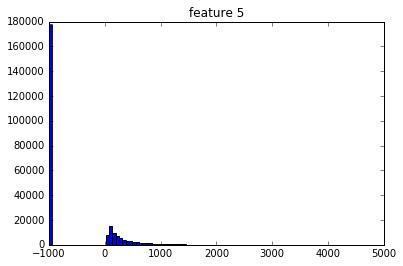

In [634]:
# Time Visualization
from ipywidgets import IntSlider, interact
from IPython.display import display

def fill_na(tx=tX, method=np.mean):
    filled = tx.copy()
    for col in columns_with_missing_values:
        tmp = filled[:, col]
        tmp[tmp == -999] = method(tmp[tmp != -999])
        filled[:, col] = tmp
    return filled

def plot_hist(tx, i, transformation=None):
    plt.figure()
    if transformation is None:
        plt.hist(tx[:, i], bins=100)
    else:
        plt.hist(transformation(tx[:, i]), bins=100)
    plt.title("feature %i" % i)
    plt.show()
    
# before processing 
interactive(lambda x:plot_hist(tX, x), x=IntSlider(min=0, max=29))

    Good Features                   : [7, 10, 14, 15, 17, 18, 20
    Suffering from outlier          : [3, 8, 19, 23, 26, 29]
    Suffering from outlier (skewed) : [1, 2, 5, 9, 13, 16, 21]
    missing values                  : [0, 4, 6, 12, 23, 24, 25, 26, 27, 28]
    categorical                     : [11, 12, 22]

In [1091]:
Good_Features                   = [7, 10, 14, 15, 17, 18, 20]
Suffering_from_outlier          = [3, 8, 19, 23, 26, 29]
Suffering_from_outlier_skewed   = [1, 2, 5, 9, 13, 16, 21]
missing_values                  = [0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28]
categorical                     = [11, 12, 22]
non_categorical                 = [x for x in range(30) if x not in categorical]
Features_with_outlier           = np.union1d(Suffering_from_outlier_skewed, Suffering_from_outlier)

In [1014]:
completeness_status_tX = np.sum(tX == -999, axis=1)
non_missing_tX         = tX[completeness_status_tX==0, :]
missing_tX             = tX[completeness_status_tX!=0, :]

In [1067]:
def logs_of_features(tx, feature_lists):
    return np.log(tx[:, feature_lists] + 1e-8)

def decompose_categorical_features(tx):
    # For feature tx{:, 11}
    tmp11 = 1 * (tx[:, 11] > 0)    
    tmp12 = 1 * (tx[:, 12] > 0.5)
    
    tmp22_0 = tx[:, 22].copy()
    tmp22_0 = 1 * (tmp22_0 == 0)
    
    tmp22_1 = tx[:, 22].copy()
    tmp22_1 = 1 * (tmp22_1 == 1)
    
    tmp22_2 = tx[:, 22].copy()
    tmp22_2 = 1 * (tmp22_2 == 2)
    
    tmp22_3 = tx[:, 22].copy()
    tmp22_3 = 1 * (tmp22_3 == 3)

    m = np.c_[tmp11, tmp12, tmp22_0, tmp22_1, tmp22_2, tmp22_3]
    if np.linalg.matrix_rank(m) < 6:
        print (np.linalg.matrix_rank(m))
        print (m)
        print ("Feature decomposition results in singularity")
    return m

In [1114]:
poly_tX.shape[1]

108

In [1116]:
decomposed_tX.shape[1]

6

In [1119]:
w[108:114]

array([ 0.15116186,  0.21826215, -5.04049425,  3.73928037,  3.21179471,
        2.19237402])

In [1113]:
th=10
print(np.arange(len(w))[abs(w > th)])
w[abs(w)> th]

[ 0  2  7 31 37 47 54 55 56 61 63 73 84 91 98]


array([ 19.08872793,  14.30756479,  16.4090869 , -61.42722856,
       -37.28161281,  12.12797737, -38.44387495, -31.61727634,
        11.0479459 ,  10.02961668,  94.00667723,  11.43962656,
        71.9602947 , -18.22266129,  35.28852604, -24.39112541,
        36.87640824, -16.33589521, -28.63099965,  11.11530519,
       -11.30043654, -59.94103878, -10.06137713, -73.97941383,
        24.33272386, -11.76771908, -21.95944171,  13.00005561,  10.54535122])

In [1103]:
# engineered_tX = 
no_missing_featuers = [i for i in range(30) if i not in missing_values]

filled_tX           = fill_na(tX, np.median)
log_tX              = logs_of_features(filled_tX, Features_with_outlier)
decomposed_tX       = decompose_categorical_features(filled_tX)
poly_tX             = build_polynomial_without_mixed_term(filled_tX[:, non_categorical], degree=4)

tX8, mean_x, std_x = standardize(np.c_[poly_tX, decomposed_tX, log_tX])

training_ratio = 0.9
y8 = transform_y(y)
train_tX8, cv_tX8, train_y8, cv_y8 = split_data(tX8, y8, training_ratio)
cv_tX8.shape

(25000, 128)

In [1124]:
idxes = np.arange(300)
# cols = np.array([ 3, 20, 22, 39])
cols = np.arange(train_tX8.shape[1])
L = np.linalg.eigvals(train_tX8[idxes][:, cols].T @ train_tX8[idxes][:, cols]).max()
print(1/L)

w = logistic_AGDR(train_y8[idxes], train_tX8[idxes][:, cols], gamma=1/L, 
                   max_iters = 100000, lambda_=0.0001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX8[idxes][:, cols], train_y8[idxes], 
                                         cv_tX8[:, cols], cv_y8, w)
print(tr_acc, te_acc)

0.000175127525558
Losgistic Regression(0/100000): loss=1048.668438268728
Losgistic Regression(100/100000): loss=137.74977623127228
Losgistic Regression(200/100000): loss=107.67354656163215
Losgistic Regression(300/100000): loss=100.1708774298158
Losgistic Regression(400/100000): loss=96.11517199548318
Losgistic Regression(500/100000): loss=92.55801068925695
Losgistic Regression(600/100000): loss=85.80416093288075
Losgistic Regression(700/100000): loss=79.90494207214722
Losgistic Regression(800/100000): loss=74.61366508674054
Losgistic Regression(900/100000): loss=69.03141771862849
Losgistic Regression(1000/100000): loss=62.9531181591113
Losgistic Regression(1100/100000): loss=57.958126857889404
Losgistic Regression(1200/100000): loss=53.887712060175396
Losgistic Regression(1300/100000): loss=50.21579936837567
Losgistic Regression(1400/100000): loss=46.9277166190745
Losgistic Regression(1500/100000): loss=43.915171597247095
Losgistic Regression(1600/100000): loss=41.04227775427714
Losgi

## 

In [1126]:
# engineered_tX = 
no_missing_featuers = [i for i in range(30) if i not in missing_values]

filled_tX           = fill_na(tX, np.median)
log_tX              = logs_of_features(filled_tX, Features_with_outlier)
decomposed_tX       = decompose_categorical_features(filled_tX)
poly_tX             = build_polynomial_without_mixed_term(filled_tX[:, non_categorical], degree=5)

tX8, mean_x, std_x = standardize(np.c_[poly_tX, log_tX])

training_ratio = 0.9
y8 = transform_y(y)
train_tX8, cv_tX8, train_y8, cv_y8 = split_data(tX8, y8, training_ratio)
cv_tX8.shape

(25000, 149)

In [1135]:
idxes = np.arange(10000)
# cols = np.array([ 3, 20, 22, 39])
cols = np.arange(train_tX8.shape[1])
L = np.linalg.eigvals(train_tX8[idxes][:, cols].T @ train_tX8[idxes][:, cols]).max()
print(1/L)

w = logistic_AGDR(train_y8[idxes], train_tX8[idxes][:, cols], gamma=1/L, 
                   max_iters = 100000, lambda_=0.1, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX8[idxes][:, cols], train_y8[idxes], 
                                         cv_tX8[:, cols], cv_y8, w)
print(tr_acc, te_acc)

6.02316980927e-06
Losgistic Regression(0/100000): loss=42093.73794136925
Losgistic Regression(100/100000): loss=5276.098018050719
Losgistic Regression(200/100000): loss=4544.430018019927
Losgistic Regression(300/100000): loss=4398.393022698131
Losgistic Regression(400/100000): loss=4335.590978131491
Losgistic Regression(500/100000): loss=4295.4604567826955
Losgistic Regression(600/100000): loss=4253.764295775035
Losgistic Regression(700/100000): loss=4220.572169570715
Losgistic Regression(800/100000): loss=4188.1499211171185
Losgistic Regression(900/100000): loss=4162.686750729248
Losgistic Regression(1000/100000): loss=4150.683255933189
Losgistic Regression(1100/100000): loss=4147.632724808571
Losgistic Regression(1200/100000): loss=4147.885647637343
Losgistic Regression(1300/100000): loss=4148.098606411034
Losgistic Regression(1400/100000): loss=4148.27532452301
Losgistic Regression(1500/100000): loss=4148.421051091622
Losgistic Regression(1600/100000): loss=4148.541389458011
Losgist

In [1133]:
w[abs(w>3)]

array([ 7.00702259,  4.57459022,  3.72892952,  7.13106015,  4.95173598,
        6.26408165,  3.19347592])

## If we only use those features not missing

It will lose important information

In [647]:
no_missing_featuers = [i for i in range(30) if i not in columns_with_missing_values]

In [648]:
tmp = build_polynomial_without_mixed_term(tX[:, no_missing_featuers], degree = 3)
tX6, mean_x6, std_x6 = standardize(tmp)
y6 = transform_y(y)
tX6.shape

(250000, 58)

In [649]:
training_ratio = 0.9
train_tX6, cv_tX6, train_y6, cv_y6 = split_data(tX6, y6, training_ratio)
cv_tX6.shape

(25000, 58)

In [652]:
idxes = np.arange(5000)
L = np.linalg.eigvals(train_tX6[idxes].T @ train_tX6[idxes]).max()
print(1/L)

w, losses = reg_logistic_regression_GD(train_y6[idxes], train_tX6[idxes], gamma=1/L, 
                   max_iters = 100000, lambda_=0.0001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX6[idxes], train_y6[idxes], cv_tX6, cv_y6, w)
print(tr_acc, te_acc)

9.5626812771e-05
Losgistic Regression(0/10000): loss=56635.91876811694
Losgistic Regression(1000/10000): loss=-70010.60927836965
Losgistic Regression(2000/10000): loss=-85440.47538549885
Losgistic Regression(3000/10000): loss=-94429.26704526579
Losgistic Regression(4000/10000): loss=-100765.83908769637
Losgistic Regression(5000/10000): loss=-105695.19605704182
Losgistic Regression(6000/10000): loss=-109808.0258851113
Losgistic Regression(7000/10000): loss=-113411.64391236744
Losgistic Regression(8000/10000): loss=-116671.54858691993
Losgistic Regression(9000/10000): loss=-119669.28184539902
0.798 0.76268


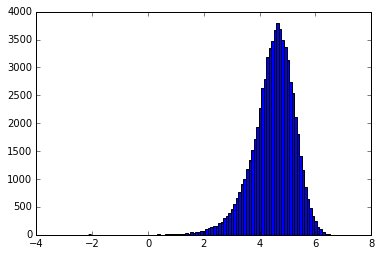

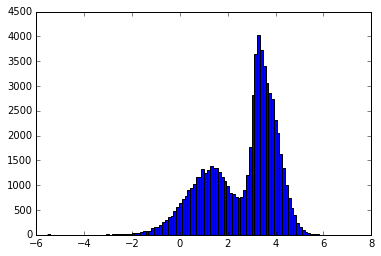

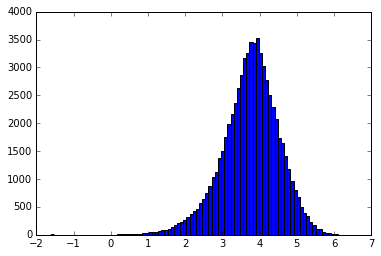

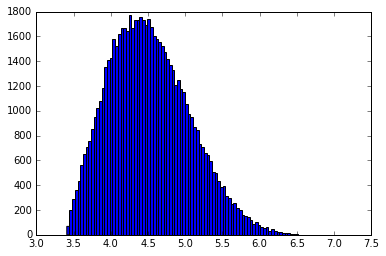

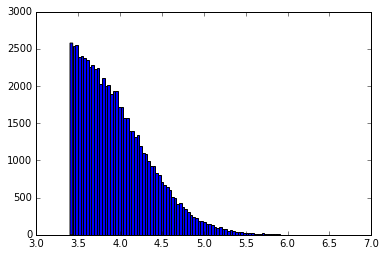

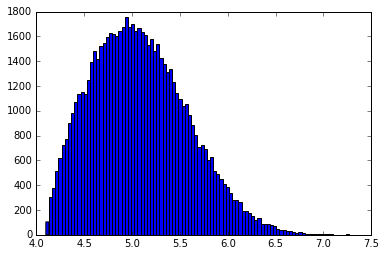

In [1012]:
for i in Suffering_from_outlier:
    plt.hist(np.log(non_missing_tX[:, i]+1e-8),bins=100)
    plt.show()

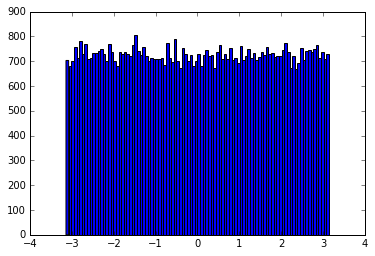

In [963]:
n = 28
plt.hist(tX[tX[:, n] != -999, n],bins=100)
plt.show()

#### Expand features to reduce bias

In [133]:
def build_polynomial_without_mixed_term(tx, degree=2):
    n = tx.shape[0]
    tmp = tx
    for i in range(2, degree+1):
        tmp = np.c_[tmp, tx**i]
    # The function standardize will add a column of 1s in the first column
    return tmp

build_polynomial_without_mixed_term(np.arange(10).reshape(5,2), 3)

array([[  0,   1,   0,   1,   0,   1],
       [  2,   3,   4,   9,   8,  27],
       [  4,   5,  16,  25,  64, 125],
       [  6,   7,  36,  49, 216, 343],
       [  8,   9,  64,  81, 512, 729]])

## Classifier 1

specifications
    - polynomial of degree 2
    - didin't apply log to some features
    - validation (not cross validation)

fill -999 with mean/median/...

In [119]:
filled_tX = fill_na()

columns_non_negative = []
for i in range(n_total_features):
    if len(filled_tX[filled_tX[:, i] < 0, i]) == 0:
        columns_non_negative.append(i)

columns_non_negative

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 16, 19, 21, 22, 23, 26, 29]

Here is the data used for interactive data analysis.

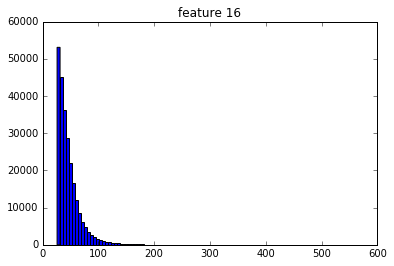

In [122]:
interactive(lambda x:plot_hist(filled_tX, x), x=IntSlider(value=1, min=0, max=n_total_features-1))

In [117]:
# some of the data is not allowed to perform log
def plot_function(idx):
    if idx in columns_non_negative:
        plot_hist(filled_tX, idx, lambda y: np.log(y+1e-6))
    else:
        pass
    
interactive(plot_function, idx=IntSlider(value=1, min=0, max=n_total_features-1))

#### standardize the columns

In [136]:
tmp = build_polynomial_without_mixed_term(filled_tX, degree = 2)
## We can take logs of each column Here *******************************
tX1, mean_x1, std_x1 = standardize(tmp)
y1 = transform_y(y)
tX1.shape

(250000, 61)

### sepearte training sets and cross validation sets and Predict w

In [546]:
training_ratio = 0.9
train_tX1, cv_tX1, train_y1, cv_y1 = split_data(tX1, y1, training_ratio)
cv_tX1.shape

(25000, 61)

In [547]:
plot_info = np.array(info)
sizes = plot_info[:, 2]
tr_error = plot_info[:, 0]
te_error = plot_info[:, 1]

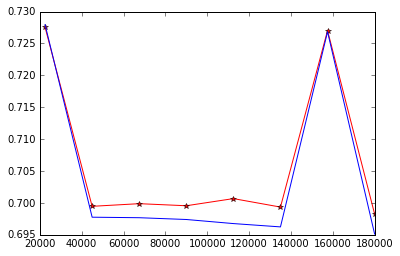

In [548]:
plt.plot(sizes, tr_error, 'r*-', sizes, te_error, 'b-')
plt.show()

## For how large the size, we can train it very accurately

gamma=0.1
lambda=0.01

|training size|iteration| acc train| acc test|
|:--:|:---:|:---:|
|100|1000| 0.98|0.70|
|150|1000|0.88|0.7|
|150|5000|0.93|0.71|
|150|10000|0.96|0.72464|
|150|20000|0.947|0.707|
|150|20000|0.953333333333| 0.70664|
|200|10000|0.885| 0.70876|
|10000|1000|0.6934| 0.69128|

we can see that with the grow of training size, the same classifier performs bad on traing set very quickly. For the same training sets, the grows of iterations can improve training performance, but can hardly influence test error.

Our model suffers from bias.

In [554]:
idxes = np.arange(200)
w, losses = reg_logistic_regression_GD(train_y1[idxes], train_tX1[idxes], gamma=0.001, 
                       max_iters = 2000, lambda_=0, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX1[idxes], train_y1[idxes], cv_tX1, cv_y1, w)
print(tr_acc, te_acc)

Losgistic Regression(0/2000): loss=-4257.306958500683
Losgistic Regression(1000/2000): loss=-16823.984342794996
0.845 0.73416


We see that the (original) feature 2, 4, 15, 18 has small feature in in it self, but their square can be large

# Classfier 2: Higher Order Polynomial

In [356]:
filled_tX = fill_na()

columns_non_negative = []
for i in range(n_total_features):
    if len(filled_tX[filled_tX[:, i] < 0, i]) == 0:
        columns_non_negative.append(i)

columns_non_negative

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 16, 19, 21, 22, 23, 26, 29]

#### standardize the columns

In [253]:
tmp = build_polynomial_without_mixed_term(filled_tX, degree = 3)
## We can take logs of each column Here *******************************
tX2, mean_x2, std_x2 = standardize(tmp)
y2 = transform_y(y)
tX2.shape

(250000, 91)

### sepearte training sets and cross validation sets and Predict w

In [260]:
training_ratio = 0.9
train_tX2, cv_tX2, train_y2, cv_y2 = split_data(tX2, y2, training_ratio)
cv_tX2.shape

(25000, 91)

In [357]:
idxes = np.arange(5000)
L=np.linalg.eigvals(train_tX2[idxes].T @ train_tX2[idxes]).max()
print(1/L)
w, losses = reg_logistic_regression_GD(train_y2[idxes], train_tX2[idxes], gamma=1/L, 
                       max_iters = 100000, lambda_=0.0001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX2[idxes], train_y2[idxes], cv_tX2, cv_y2, w)
print(tr_acc, te_acc)

1.31858812606e-05
Losgistic Regression(0/100000): loss=-1576381.4131746194
Losgistic Regression(1000/100000): loss=-2609588.730715125
Losgistic Regression(2000/100000): loss=-3167813.2138219867
Losgistic Regression(3000/100000): loss=-3472116.763273852
Losgistic Regression(4000/100000): loss=-3685713.505443715
Losgistic Regression(5000/100000): loss=-3849144.4587358832
Losgistic Regression(6000/100000): loss=-3981252.780542511
Losgistic Regression(7000/100000): loss=-4091986.6941092336
Losgistic Regression(8000/100000): loss=-4187103.3739277883
Losgistic Regression(9000/100000): loss=-4270247.950210498
Losgistic Regression(10000/100000): loss=-4343888.490349865
Losgistic Regression(11000/100000): loss=-4409771.966527175
Losgistic Regression(12000/100000): loss=-4469173.647771348
Losgistic Regression(13000/100000): loss=-4523053.768381426
Losgistic Regression(14000/100000): loss=-4572165.075756724
Losgistic Regression(15000/100000): loss=-4617120.198719306
Losgistic Regression(16000/100

In [364]:
idxes = np.arange(10000)
L=np.linalg.eigvals(train_tX2[idxes].T @ train_tX2[idxes]).max()
print(1/L)
w, losses = reg_logistic_regression_GD(train_y2[idxes], train_tX2[idxes], gamma=1/L, 
                       max_iters = 100000, lambda_=0.0001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX2[idxes], train_y2[idxes], cv_tX2, cv_y2, w)
print(tr_acc, te_acc)

6.6932772662e-06
Losgistic Regression(0/100000): loss=434457.21842224855
Losgistic Regression(1000/100000): loss=-10234622.776920963
Losgistic Regression(2000/100000): loss=-12230873.927219868
Losgistic Regression(3000/100000): loss=-13370184.385959959
Losgistic Regression(4000/100000): loss=-14177368.686676051
Losgistic Regression(5000/100000): loss=-14804224.395295477
Losgistic Regression(6000/100000): loss=-15313039.706620015
Losgistic Regression(7000/100000): loss=-15737437.263241317
Losgistic Regression(8000/100000): loss=-16098504.39866479
Losgistic Regression(9000/100000): loss=-16410311.024095053
Losgistic Regression(10000/100000): loss=-16682700.350381702
Losgistic Regression(11000/100000): loss=-16922849.827691004
Losgistic Regression(12000/100000): loss=-17136175.98913687
Losgistic Regression(13000/100000): loss=-17326879.368117437
Losgistic Regression(14000/100000): loss=-17498293.407778494
Losgistic Regression(15000/100000): loss=-17653107.48084559
Losgistic Regression(160

In [330]:
np.arange(91)[abs(w)>1]%30

array([ 0,  7, 10, 13, 16,  0,  2,  8,  9, 13, 19,  0,  1,  3,  9, 13, 19,
        0])

# Classifier 3

In [467]:
def build_polynomial_without_mixed_term_with_log(tx, log_cols, degree=2):
    n = tx.shape[0]
    tmp = tx
    for i in range(2, degree+1):
        tmp = np.c_[tmp, tx**i]
        
    tmp = np.c_[tmp, np.log(tx[:, log_cols] + 1e-6)]
    tmp = np.c_[tmp, (np.log(tx[:, log_cols] + 1e-6))**2]
    tmp = np.c_[tmp, (np.log(tx[:, log_cols] + 1e-6))**3]
    return tmp

build_polynomial_without_mixed_term_with_log(np.arange(10).reshape(5,2), [1], 2)

array([[  0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   9.99999500e-07,   9.99999000e-13,
          9.99998500e-19],
       [  2.00000000e+00,   3.00000000e+00,   4.00000000e+00,
          9.00000000e+00,   1.09861262e+00,   1.20694969e+00,
          1.32597017e+00],
       [  4.00000000e+00,   5.00000000e+00,   1.60000000e+01,
          2.50000000e+01,   1.60943811e+00,   2.59029104e+00,
          4.16891312e+00],
       [  6.00000000e+00,   7.00000000e+00,   3.60000000e+01,
          4.90000000e+01,   1.94591029e+00,   3.78656686e+00,
          7.36831943e+00],
       [  8.00000000e+00,   9.00000000e+00,   6.40000000e+01,
          8.10000000e+01,   2.19722469e+00,   4.82779633e+00,
          1.06077533e+01]])

In [382]:
tmp = build_polynomial_without_mixed_term_with_log(filled_tX, log_features, degree = 4)
tX3, mean_x3, std_x3 = standardize(tmp)
y3 = transform_y(y)
tX3.shape

(250000, 133)

In [383]:
training_ratio = 0.9
train_tX3, cv_tX3, train_y3, cv_y3 = split_data(tX3, y3, training_ratio)
cv_tX3.shape

(25000, 133)

In [394]:
idxes = np.arange(5000)
L=np.linalg.eigvals(train_tX3[idxes].T @ train_tX3[idxes]).max()
print(1/L)
w, losses = reg_logistic_regression_GD(train_y3[idxes], train_tX3[idxes], gamma=0.0001, 
                       max_iters = 10000, lambda_=0.00, regularizor=regularizor_ridge)

tr_acc, te_acc = prediction_and_accuracy(train_tX3[idxes], train_y3[idxes], cv_tX3, cv_y3, w)
print(tr_acc, te_acc)

1.18430305201e-05
Losgistic Regression(0/10000): loss=-2611163.012880917
Losgistic Regression(1000/10000): loss=-3936990.4564067796
Losgistic Regression(2000/10000): loss=-4313944.990193981
Losgistic Regression(3000/10000): loss=-4530935.028052804
Losgistic Regression(4000/10000): loss=-4686759.265161883
Losgistic Regression(5000/10000): loss=-4806968.908878522
Losgistic Regression(6000/10000): loss=-4904122.84751413
Losgistic Regression(7000/10000): loss=-4985372.565744881
Losgistic Regression(8000/10000): loss=-5055214.850281095
Losgistic Regression(9000/10000): loss=-5116816.102477511
0.813 0.80572


## For higher dimensions

In [399]:
tmp = build_polynomial_without_mixed_term_with_log(filled_tX, log_features, degree = 3)
tX4, mean_x4, std_x4 = standardize(tmp)
y4 = transform_y(y)
tX4.shape

(250000, 115)

In [400]:
training_ratio = 0.9
train_tX4, cv_tX4, train_y4, cv_y4 = split_data(tX4, y4, training_ratio)
cv_tX4.shape

(25000, 115)

In [440]:
idxes = np.arange(200)
L=np.linalg.eigvals(train_tX4[idxes].T @ train_tX4[idxes]).max()
print(1/L)

w = np.random.randn(train_tX4.shape[1]) * 0.1
maximum_size = train_y4.shape[0]

for i in range(10):
    idxes = np.random.randint(0, maximum_size, 2000)
    w, losses = reg_logistic_regression_SGD(train_y4[idxes], train_tX4[idxes], gamma=1/L, 
                       max_iters = 10000, lambda_=0.0001, regularizor=regularizor_lasso, w0=w)

    tr_acc, te_acc = prediction_and_accuracy(train_tX4[idxes], train_y4[idxes], cv_tX4, cv_y4, w)
    print(tr_acc, te_acc)

0.00025368797602
Losgistic Regression(0/10000): loss=-893711.0623600627
Losgistic Regression(1000/10000): loss=-944014.4622320133
Losgistic Regression(2000/10000): loss=-1033972.7961426789
Losgistic Regression(3000/10000): loss=-1083628.4283881453
Losgistic Regression(4000/10000): loss=-1114844.76407547
Losgistic Regression(5000/10000): loss=-1136101.0571259223
Losgistic Regression(6000/10000): loss=-1151420.8972547455
Losgistic Regression(7000/10000): loss=-1162947.157179648
Losgistic Regression(8000/10000): loss=-1171919.5317238276
Losgistic Regression(9000/10000): loss=-1179101.937071516
0.83 0.80236
Losgistic Regression(0/10000): loss=-888225.356995657
Losgistic Regression(1000/10000): loss=-914899.2770507383
Losgistic Regression(2000/10000): loss=-951666.3112675188
Losgistic Regression(3000/10000): loss=-972020.5028958153
Losgistic Regression(4000/10000): loss=-986281.9179660012
Losgistic Regression(5000/10000): loss=-997211.5103137465
Losgistic Regression(6000/10000): loss=-10060

In [442]:
tr_acc, te_acc = prediction_and_accuracy(train_tX4[idxes], train_y4[idxes], cv_tX4, cv_y4, w)
print(tr_acc, te_acc)

0.8205 0.80228


## For Higher Dimensions

In [858]:
tmp = build_polynomial_without_mixed_term_with_log(filled_tX, log_features, degree = 5)
tX5, mean_x5, std_x5 = standardize(tmp)
y5 = transform_y(y)
tX5.shape

(250000, 187)

In [645]:
training_ratio = 0.9
train_tX5, cv_tX5, train_y5, cv_y5 = split_data(tX5, y5, training_ratio)
cv_tX5.shape

(25000, 187)

In [646]:
idxes = np.arange(2000)
L = np.linalg.eigvals(train_tX5[idxes].T @ train_tX5[idxes]).max()
print(1/L)

w, losses = reg_logistic_regression_GD(train_y5[idxes], train_tX5[idxes], gamma=1/L, 
                   max_iters = 20000, lambda_=0.0001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX5[idxes], train_y5[idxes], cv_tX5, cv_y5, w)
print(tr_acc, te_acc)

2.23143465589e-05
Losgistic Regression(0/20000): loss=-152948.4985915193
Losgistic Regression(1000/20000): loss=-558222.8949306096
Losgistic Regression(2000/20000): loss=-641129.1642222997
Losgistic Regression(3000/20000): loss=-694583.4965614841
Losgistic Regression(4000/20000): loss=-733162.1216511249
Losgistic Regression(5000/20000): loss=-763211.2116422988
Losgistic Regression(6000/20000): loss=-787804.3128164957
Losgistic Regression(7000/20000): loss=-808619.5440130396
Losgistic Regression(8000/20000): loss=-826656.972967146
Losgistic Regression(9000/20000): loss=-842556.2018722652
Losgistic Regression(10000/20000): loss=-856751.7948597504
Losgistic Regression(11000/20000): loss=-869553.7814276543
Losgistic Regression(12000/20000): loss=-881193.2501136299
Losgistic Regression(13000/20000): loss=-891847.882410691
Losgistic Regression(14000/20000): loss=-901657.8873610676
Losgistic Regression(15000/20000): loss=-910736.4680695792
Losgistic Regression(16000/20000): loss=-919176.28158

## If we only use those features not missing

It will lose important information

In [861]:
tmp = build_polynomial_without_mixed_term(tX[:, no_missing_featuers], degree = 3)
tX6, mean_x6, std_x6 = standardize(tmp)
y6 = transform_y(y)
tX6.shape

(250000, 58)

In [862]:
training_ratio = 0.9
train_tX6, cv_tX6, train_y6, cv_y6 = split_data(tX6, y6, training_ratio)
cv_tX6.shape

(25000, 58)

In [864]:
threshold = 5
print(w[abs(w)>threshold])
np.arange(len(w))[abs(w)>threshold]

[ 5.12022288 -8.43261199 -6.13306021  5.49985935]


array([ 3, 20, 22, 39])

In [865]:
idxes = np.arange(10000)
# cols = np.array([ 3, 20, 22, 39])
cols = np.arange(train_tX6.shape[1])
L = np.linalg.eigvals(train_tX6[idxes][:, cols].T @ train_tX6[idxes][:, cols]).max()
print(1/L)

w, losses = reg_logistic_regression_GD(train_y6[idxes], train_tX6[idxes][:, cols], gamma=1/L, 
                   max_iters = 10000, lambda_=0.000, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX6[idxes][:, cols], train_y6[idxes], 
                                         cv_tX6[:, cols], cv_y6, w)
print(tr_acc, te_acc)

9.38726863049e-06
Losgistic Regression(0/10000): loss=172062.31224921555
Losgistic Regression(1000/10000): loss=-906856.8877039328
Losgistic Regression(2000/10000): loss=-2222880.6517023114
Losgistic Regression(3000/10000): loss=-2897843.0219437107
Losgistic Regression(4000/10000): loss=-3356243.367217049
Losgistic Regression(5000/10000): loss=-3704817.9229270555
Losgistic Regression(6000/10000): loss=-3985748.037510811
Losgistic Regression(7000/10000): loss=-4219904.215027729
Losgistic Regression(8000/10000): loss=-4419567.694428677
Losgistic Regression(9000/10000): loss=-4592789.371367343
0.7818 0.77852


In [845]:
idxes = np.arange(10000)
# cols = np.array([ 3, 20, 22, 39])
cols = np.arange(train_tX6.shape[1])
L = np.linalg.eigvals(train_tX6[idxes][:, cols].T @ train_tX6[idxes][:, cols]).max()
print(1/L)

w = logistic_AGDR(train_y6[idxes], train_tX6[idxes][:, cols], gamma=1/L, 
                   max_iters = 100000, lambda_=0.0001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX6[idxes][:, cols], train_y6[idxes], 
                                         cv_tX6[:, cols], cv_y6, w)
print(tr_acc, te_acc)

9.38726863049e-06
Losgistic Regression(0/100000): loss=-35582399.471180476
Losgistic Regression(1000/100000): loss=-7323507.9188665375
Totoal number of iterations =  1865
Loss =  -8238216.81808
0.7911 0.78972


# Better results

In [764]:
no_missing_featuers = [i for i in range(30) if i not in columns_with_missing_values]

In [766]:
non_missing_tX = tX[status_tX == 0, :]
missing_tX = tX[status_tX != 0, :]

In [866]:
tmp = build_polynomial_without_mixed_term(fill_na(tX, np.median), degree=4)
tX7, mean_x7, std_x7 = standardize(tmp)
y7 = transform_y(y)
tX7.shape

(250000, 121)

In [867]:
training_ratio = 0.9
train_tX7, cv_tX7, train_y7, cv_y7 = split_data(tX7, y7, training_ratio)
cv_tX7.shape

(25000, 121)

In [817]:
idxes = np.arange(5000)
L = np.linalg.eigvals(train_tX7[idxes].T @ train_tX7[idxes]).max()
print(1/L)

w, losses = reg_logistic_regression_GD(train_y7[idxes], train_tX7[idxes], gamma=0.0001, 
                   max_iters = 100000, lambda_=0.00001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX7[idxes], train_y7[idxes], cv_tX7, cv_y7, w)
print(tr_acc, te_acc)

1.29134200029e-05
Losgistic Regression(0/100000): loss=-1864570.8664358312
Losgistic Regression(1000/100000): loss=-3643706.596277618
Losgistic Regression(2000/100000): loss=-4075325.443160949
Losgistic Regression(3000/100000): loss=-4287686.346307418
Losgistic Regression(4000/100000): loss=-4422673.567931138
Losgistic Regression(5000/100000): loss=-4520877.584452401
Losgistic Regression(6000/100000): loss=-4598137.39963385
Losgistic Regression(7000/100000): loss=-4662064.837419295
Losgistic Regression(8000/100000): loss=-4716886.13889026
Losgistic Regression(9000/100000): loss=-4765307.290995987
Losgistic Regression(10000/100000): loss=-4809598.738261102
Losgistic Regression(11000/100000): loss=-4851464.061950497
Losgistic Regression(12000/100000): loss=-4890956.69237179
Losgistic Regression(13000/100000): loss=-4927619.743856777
Losgistic Regression(14000/100000): loss=-4961382.561498515
Losgistic Regression(15000/100000): loss=-4992435.593707586
Losgistic Regression(16000/100000): l

In [824]:
print(w[abs(w>5)])
print(np.arange(len(w))[abs(w>3)])

[  6.54558852   6.64933073  12.05224732   6.48064661]
[ 0  7 34 61 62 90 92 97]


In [816]:
idxes = np.arange(10000)
L = np.linalg.eigvals(train_tX7[idxes].T @ train_tX7[idxes]).max()
print(1/L)

w, losses = reg_logistic_regression_GD(train_y7[idxes], train_tX7[idxes], gamma=0.0001, 
                   max_iters = 150000, lambda_=0.00001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX7[idxes], train_y7[idxes], cv_tX7, cv_y7, w)
print(tr_acc, te_acc)

6.37656429545e-06
Losgistic Regression(0/150000): loss=-24496155.36677372
Losgistic Regression(1000/150000): loss=-16726315.597480152
Losgistic Regression(2000/150000): loss=-17252993.276240055
Losgistic Regression(3000/150000): loss=-17436995.475730643


KeyboardInterrupt: 

In [704]:
idxes = np.arange(10000)
L = np.linalg.eigvals(train_tX7[idxes].T @ train_tX7[idxes]).max()
print(1/L)

w, losses = reg_logistic_regression_GD(train_y7[idxes], train_tX7[idxes], gamma=1/L, 
                   max_iters = 200000, lambda_=0.0001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX7[idxes], train_y7[idxes], cv_tX7, cv_y7, w)
print(tr_acc, te_acc)

6.37656429545e-06
Losgistic Regression(0/200000): loss=9221233.193410587
Losgistic Regression(1000/200000): loss=-8296709.870189696
Losgistic Regression(2000/200000): loss=-9862373.335854245
Losgistic Regression(3000/200000): loss=-10831655.627667965
Losgistic Regression(4000/200000): loss=-11536115.326674325
Losgistic Regression(5000/200000): loss=-12075983.19691701
Losgistic Regression(6000/200000): loss=-12511679.921146508
Losgistic Regression(7000/200000): loss=-12874634.530713344
Losgistic Regression(8000/200000): loss=-13183781.813886058
Losgistic Regression(9000/200000): loss=-13451475.683294827
Losgistic Regression(10000/200000): loss=-13686264.729243582
Losgistic Regression(11000/200000): loss=-13894353.282241577
Losgistic Regression(12000/200000): loss=-14080409.165111527
Losgistic Regression(13000/200000): loss=-14248028.215456463
Losgistic Regression(14000/200000): loss=-14400034.902295291
Losgistic Regression(15000/200000): loss=-14538685.367201654
Losgistic Regression(160

In [763]:
idxes = np.arange(5000)
L = np.linalg.eigvals(train_tX7[idxes].T @ train_tX7[idxes]).max()
print(1/L)
w, losses = reg_logistic_regression_GD(train_y7[idxes], train_tX7[idxes], gamma=1/L, 
               max_iters = 500000, lambda_= 1e-6, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX7[idxes], train_y7[idxes], cv_tX7, cv_y7, w)
print(i, tr_acc, te_acc)

(3.69755411847e-06+0j)
Losgistic Regression(0/500000): loss=(2050782.064924333+0j)


KeyboardInterrupt: 

In [719]:
correlation_list = []
for i in range(len(w)-1):
    correlation_list.append(np.corrcoef(train_y7, train_tX7[:, i])[0, 1])

In [722]:
c = np.array(correlation_list)

array([  2.65129855e-02,  -3.51612919e-01,  -1.38712350e-02,
         1.91876052e-01,   2.03718015e-01,   2.13023438e-01,
        -1.83174366e-01,   1.31601540e-02,  -1.51333685e-02,
         1.52662286e-01,  -1.96198138e-01,   2.72353631e-01,
         1.75387841e-01,   2.34864606e-01,  -2.94158012e-04,
        -4.79748618e-03,  -3.29888084e-02,   2.48140191e-03,
         4.86870767e-03,   2.12883597e-02,   5.62790946e-03,
         1.35090525e-01,   1.33094440e-01,   1.15036848e-01,
        -2.56697681e-04,   1.39365659e-03,   2.32211127e-02,
         1.37242072e-03,  -4.50596689e-03,   1.33843107e-01,
        -4.22503370e-02,  -2.09894679e-01,  -6.31467775e-02,
         1.06434966e-01,   2.33094856e-01,   1.75096532e-01,
         1.81317012e-01,  -1.37815655e-02,   2.06173286e-03,
         8.84978519e-02,  -1.00459724e-01,   4.62967153e-02,
         2.13143137e-01,   1.26363568e-01,  -1.12019572e-01,
        -1.44671666e-03,  -1.92796971e-02,  -1.46377790e-01,
        -2.47121748e-03,

In [728]:
np.arange(len(c))[abs(c) < 0.01]

array([ 14,  15,  17,  18,  20,  24,  25,  27,  28,  38,  45,  48,  50,
        56,  68,  74,  75,  76,  77,  78,  79,  80,  84,  85,  86,  87,
        88,  89,  93,  98, 103, 105, 106, 108, 109, 110, 116, 119])

In [730]:
np.arange(len(w))[abs(w) < 0.1]

array([  2,   6,   9,  11,  14,  15,  20,  24,  25,  27,  36,  41,  47,
        48,  50,  55,  56,  68,  72,  74,  75,  77,  80,  82,  84,  85,
        87, 101, 104, 108, 110, 115, 117])

## Best Results ever

In [882]:
idxes = np.arange(10000)
L = np.linalg.eigvals(train_tX7[idxes].T @ train_tX7[idxes]).max()
print(1/L)

w, losses = reg_logistic_regression_GD(train_y7[idxes], train_tX7[idxes], gamma=0.0001, 
                   max_iters = 150000, lambda_=0.00001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX7[idxes], train_y7[idxes], cv_tX7, cv_y7, w)
print(tr_acc, te_acc)

6.37656429545e-06
Losgistic Regression(0/150000): loss=6128.661958753694
Losgistic Regression(1000/150000): loss=4382.793973805763
Losgistic Regression(2000/150000): loss=4321.439300698346
Losgistic Regression(3000/150000): loss=4291.208251980238
Losgistic Regression(4000/150000): loss=4270.574245773539
Losgistic Regression(5000/150000): loss=4255.255208797125
Losgistic Regression(6000/150000): loss=4244.187346417512
Losgistic Regression(7000/150000): loss=4236.342382593083
Losgistic Regression(8000/150000): loss=4229.2149455352765
Losgistic Regression(9000/150000): loss=4222.549848793302
Losgistic Regression(10000/150000): loss=4216.256821112506
Losgistic Regression(11000/150000): loss=4210.280363793595
Losgistic Regression(12000/150000): loss=4204.581620909371
Losgistic Regression(13000/150000): loss=4199.130612876477
Losgistic Regression(14000/150000): loss=4193.902700925177
Losgistic Regression(15000/150000): loss=4188.876869375156
Losgistic Regression(16000/150000): loss=4184.0348

In [902]:
idxes = np.arange(20000)
L = np.linalg.eigvals(train_tX7[idxes].T @ train_tX7[idxes]).max()
print(1/L)

w_agdr = logistic_AGDR(train_y7[idxes], train_tX7[idxes], gamma=1/L, 
                   max_iters = 150000, lambda_=0.00001, regularizor=regularizor_lasso, w0=w_agdr)

tr_acc, te_acc = prediction_and_accuracy(train_tX7[idxes], train_y7[idxes], 
                                         cv_tX7, cv_y7, w_agdr)
print(tr_acc, te_acc)

2.79002650416e-06
Losgistic Regression(0/150000): loss=7981.108636380177
Losgistic Regression(100/150000): loss=7981.110107054736
0.00147067455873
Totoal number of iterations =  100
Loss =  7981.11010705
0.8212 0.8158


In [898]:
w_agdr

array([  1.03230119e+01,   8.72829146e-01,   1.80618295e+00,
         1.76614532e-01,  -1.91718656e+00,  -1.73407054e+00,
        -1.32845968e-01,   9.99409928e+00,  -7.84458112e-02,
        -3.32218947e-01,  -2.93981054e+00,   6.25846578e-02,
         2.12576775e-01,  -3.39203801e-01,   4.39780896e-02,
         1.62641950e-02,   2.70709896e+00,   3.43499201e-02,
         4.74550806e-04,  -4.25686853e-01,   3.12686061e-02,
         1.08517303e+00,   1.53254173e-01,   1.58320298e+00,
        -3.96805792e-02,  -1.08817579e-02,   9.38729270e-01,
         4.75880670e-02,  -3.50876529e-02,  -2.82148526e-01,
        -2.61762925e+01,  -6.11373725e+00,  -1.23944036e+01,
         1.76741777e+00,   7.22834343e+00,   5.69466116e+00,
        -8.47058102e-02,  -1.86781609e+01,   8.90956905e-01,
        -8.66581649e-01,   4.15964929e+00,   2.46080678e-01,
        -3.35989271e-01,   1.86089696e+00,  -1.25807891e-01,
        -1.22027872e-02,  -2.70569586e+00,  -5.39981561e-02,
        -8.49681047e-03,

In [900]:
w1 = w_agdr
w1

array([  1.03230119e+01,   8.72829146e-01,   1.80618295e+00,
         1.76614532e-01,  -1.91718656e+00,  -1.73407054e+00,
        -1.32845968e-01,   9.99409928e+00,  -7.84458112e-02,
        -3.32218947e-01,  -2.93981054e+00,   6.25846578e-02,
         2.12576775e-01,  -3.39203801e-01,   4.39780896e-02,
         1.62641950e-02,   2.70709896e+00,   3.43499201e-02,
         4.74550806e-04,  -4.25686853e-01,   3.12686061e-02,
         1.08517303e+00,   1.53254173e-01,   1.58320298e+00,
        -3.96805792e-02,  -1.08817579e-02,   9.38729270e-01,
         4.75880670e-02,  -3.50876529e-02,  -2.82148526e-01,
        -2.61762925e+01,  -6.11373725e+00,  -1.23944036e+01,
         1.76741777e+00,   7.22834343e+00,   5.69466116e+00,
        -8.47058102e-02,  -1.86781609e+01,   8.90956905e-01,
        -8.66581649e-01,   4.15964929e+00,   2.46080678e-01,
        -3.35989271e-01,   1.86089696e+00,  -1.25807891e-01,
        -1.22027872e-02,  -2.70569586e+00,  -5.39981561e-02,
        -8.49681047e-03,

# test

In [750]:
no_missing_featuers = [i for i in range(30) if i not in columns_with_missing_values]

In [658]:
status_tX =np.sum(tX == -999, axis=1)

In [883]:
non_missing_tX = tX[status_tX == 0, :]
missing_tX = tX[status_tX != 0, :]

In [751]:
tmp = build_polynomial_without_mixed_term(fill_na(tX, np.median), degree=10)
tX7, mean_x7, std_x7 = standardize(tmp)
y7 = transform_y(y)
tX7.shape

(250000, 301)

In [759]:
training_ratio = 0.9
train_tX7, cv_tX7, train_y7, cv_y7 = split_data(tX7, y7, training_ratio)
cv_tX7.shape

(25000, 301)

In [758]:
idxes = np.arange(1000)
L = np.linalg.eigvals(train_tX7[idxes].T @ train_tX7[idxes]).max()
print(1/L)

w, losses = reg_logistic_regression_GD(train_y7[idxes], train_tX7[idxes], gamma=1e-5, 
                   max_iters = 100000, lambda_=0.0001, regularizor=regularizor_lasso)

tr_acc, te_acc = prediction_and_accuracy(train_tX7[idxes], train_y7[idxes], cv_tX7, cv_y7, w)
print(tr_acc, te_acc)

(3.49473614186e-05+0j)
Losgistic Regression(0/100000): loss=-44619.0435651786
Losgistic Regression(1000/100000): loss=-154856.83025499398
Losgistic Regression(2000/100000): loss=-142309.8661505646
Losgistic Regression(3000/100000): loss=-145717.54056625118
Losgistic Regression(4000/100000): loss=-152960.1357161893
Losgistic Regression(5000/100000): loss=-159643.1937239881
Losgistic Regression(6000/100000): loss=-165739.41687550774
Losgistic Regression(7000/100000): loss=-171345.22204597376
Losgistic Regression(8000/100000): loss=-176512.10742339757
Losgistic Regression(9000/100000): loss=-181282.82337985822
Losgistic Regression(10000/100000): loss=-185699.22739621307
Losgistic Regression(11000/100000): loss=-189801.72317867383
Losgistic Regression(12000/100000): loss=-193628.15191199194
Losgistic Regression(13000/100000): loss=-197213.15342974968
Losgistic Regression(14000/100000): loss=-200587.66586620157
Losgistic Regression(15000/100000): loss=-203778.91895909168
Losgistic Regressio

# Only items whose values are good

## Generate predictions and save ouput in csv format for submission:

In [331]:
DATA_TEST_PATH = '../data/test.csv'
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [884]:
def fill_na_test(method=np.mean):
    filled = tX_test.copy()
    for col in columns_with_missing_values:
        tmp = filled[:, col]
        tmp[tmp == -999] = method(tmp[tmp != -999])
        filled[:, col] = tmp
    return filled


filled_test_tX = fill_na_test(np.median)

columns_non_negative = []
for i in range(n_total_features):
    if len(filled_test_tX[filled_test_tX[:, i] < 0, i]) == 0:
        columns_non_negative.append(i)

columns_non_negative

[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 13, 16, 19, 21, 22, 23, 26, 29]

In [688]:
tmp = build_polynomial_without_mixed_term(filled_test_tX, degree=4)
## We can take logs of each column Here *******************************
test_tX, _, _ = standardize(tmp, mean_x7, std_x7)
test_tX.shape

(568238, 121)

In [903]:
y0=transform_y_back(prediction(test_tX, w_agdr))

In [904]:
y0[y0==1].shape

(178677,)

In [888]:
y0[y0==1].shape

(176985,)

In [889]:
y0.shape

(568238,)

In [905]:
OUTPUT_PATH = '../results/result6.csv' # TODO: fill in desired name of output file for submission
y_pred = transform_y_back(y0)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)